X: torch.Size([400, 2]) Y: torch.Size([400])
     pcost       dcost       gap    pres   dres
 0: -5.0164e+00 -1.4008e+01  5e+02  2e+01  1e+00
 1: -1.7323e+00 -1.4072e+01  3e+01  7e-01  4e-02
 2: -3.1783e+00 -7.2585e+00  4e+00  2e-16  8e-16
 3: -4.0644e+00 -5.4417e+00  1e+00  9e-16  5e-16
 4: -4.5914e+00 -5.1330e+00  5e-01  1e-15  4e-16
 5: -4.8977e+00 -5.0295e+00  1e-01  1e-15  4e-16
 6: -4.9867e+00 -5.0066e+00  2e-02  3e-15  4e-16
 7: -5.0030e+00 -5.0034e+00  4e-04  7e-15  4e-16
 8: -5.0033e+00 -5.0033e+00  4e-06  4e-16  4e-16
Optimal solution found.
21 support vectors out of 400 points


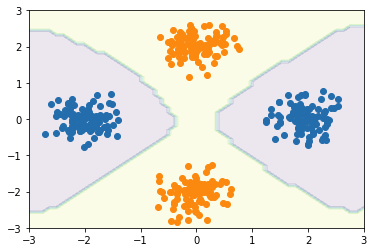

In [13]:
"""
kernel SVM by python:
https://pythonprogramming.net/soft-margin-kernel-cvxopt-svm-machine-learning-tutorial/

QP solver:
http://cvxopt.org/install/index.html [install package first!!]
https://cvxopt.org/userguide/coneprog.html#s-qp
https://cvxopt.org/examples/tutorial/qp.html
"""

import numpy as np
# from numpy import linalg
import torch
import cvxopt
import cvxopt.solvers

def linear_kernel(x1, x2):
    """
    x1 and x2 are np.array or torch.tensor with shape (D,) where D is the dimension.
    """
    return np.dot(x1, x2)

def gaussian_kernel(x1, x2, gamma=1):
    """
    x1 and x2 are np.array or torch.tensor with shape (D,) where D is the dimension.
    """
    return np.exp(-gamma * np.linalg.norm(x1-x2)**2)


class kernelSVM(object):
    def __init__(self, kernel, C=None):
        self.kernel = kernel
        if C is not None: # without slack variables
            self.C = float(self.C)
        else: # with slack variables
            self.C = C
        self.alpha = None
        self.sv = None
        self.sv_y = None
        self.b = 0.0
    
    def train(self, X, y):
        """
        Take in the training data and labels and then save alpha, sv, sv_y, and b.
        X: A PyTorch tensor of shape (N, D) containing N data points and each point has dimension D.
        y: A PyTorch tensor of shape (N,) containing labels for the data.
        """
        N, D = X.shape
        X, y = np.array(X), np.array(y)
        
        # Create kernel matrix K
        K = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                K[i,j] = self.kernel(X[i,:], X[j,:])
        
        # Set up QP problem
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-np.ones(N))
        A = cvxopt.matrix(y, (1,N)) # reshape as 2D
        b = cvxopt.matrix(0.0)
        #print(K[1:5,1:5],P[1:5,1:5])
        
        if self.C is None:
            G = cvxopt.matrix(np.diag(-np.ones(N)))
            h = cvxopt.matrix(np.zeros(N))
        else:
            G = cvxopt.matrix(np.vstack((np.diag(-np.ones(N)), np.identity(N))))
            h = cvxopt.matrix(np.hstack((np.zeros(N), np.ones(N)*self.C/N)))
        
        # Solve alpha by QP
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        alpha = np.ravel(solution['x'])
        
        # Save support vectors
        isSV = alpha>1e-5
        idx = np.arange(len(alpha))[isSV]
        self.alpha = alpha[isSV]
        self.sv = X[isSV]
        self.sv_y = y[isSV]
        print("%d support vectors out of %d points" % (len(self.alpha), N))
        
        # Calculate and save parameter b
        self.b = np.sum(self.sv_y)
        for r in range(len(self.alpha)):
            self.b -= np.sum(self.alpha * self.sv_y * K[idx[r], isSV])
        self.b = self.b / len(self.alpha)
    
    def predict(self, X):
        """
        Take in the test data and output a prediction torch.
        Input:
        -X: A PyTorch tensor of shape (N, D) containing N data points and each point has dimension D.
        Return:
        -y_pred: A PyTorch tensor of shape (N,) containing +1/-1 labels for the X
        """
        N, D = X.shape
        y_pred = np.zeros(N)
        if self.kernel == linear_kernel:
            W = np.zeros(D)
            for i in range(len(self.alpha)):
                W += self.alpha[i] * self.sv_y[i] * self.sv[i]
            y_pred = np.sign(np.dot(X, W) + self.b)
        else:
            for i in range(N):
                s = 0.0
                for alpha, sv_y, sv in zip(self.alpha, self.sv_y, self.sv):
                    s += alpha * sv_y * self.kernel(X[i,:], sv)
                y_pred[i] = s
            y_pred = np.sign(y_pred + self.b)
        return torch.tensor(y_pred)
    
    def plot_classifier(self, plot_range):
        """
        Note: only for D=2 now!!
        Input:
        plot_range = [x_low, x_upper, y_low, y_upper] array like 
        """
        x = np.linspace(plot_range[0], plot_range[1], 50)
        y = np.linspace(plot_range[2], plot_range[3], 50)
        xx, yy = np.meshgrid(x, y)
        X_test = np.array([[x1, x2] for x1, x2 in zip(np.ravel(xx), np.ravel(yy))])
        z_test = self.predict(X_test)
        z = np.reshape(z_test, (xx.shape))
        h = plt.contourf(x, y, z, alpha=0.1)
        plt.show()


# Test kernel SVM by toy example
from functions import *
import scipy.io as sio

# X, Y = load_data("toy_example0") # two clusters
X, Y = load_data("toy_example") # four clusters
plot_data(X, Y)

# kernel = linear_kernel
kernel = gaussian_kernel
LSVM = kernelSVM(kernel)
LSVM.train(X, Y)
y_pred = LSVM.predict
# LSVM.plot_classifier([-1, 3, -3, 1])
LSVM.plot_classifier([-3, 3, -3, 3])

In [11]:
c = np.linalg.norm(np.array([1,0,1]))
print(X.shape)
N,D = X.shape
print(N,D)

torch.Size([400, 2])
400 2
